# FRC Match Metrics
Displays the results of a FRC match in a series of charts

## Setup
In your virtual environment, install pandas and matplotlib: 
  `pip install pandas matplotlib`
* If you are using VS Code, it should ask you to install the IPython extensions.
* If this next cell runs with no errors, you are all set.

In [1]:
import util
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

## Functions to get Team and Event names
Some parts of this notebook depend on a team you are interested in.  Other parts of this notebook need to look up the team name.  This section defines a function to look up the team name.  Same things for event name.

In [12]:
def get_team_name(team_id):
    url = f'https://www.thebluealliance.com/api/v3/team/{team_id}'
    return util.call_tba_api(url).json()['nickname']

def get_event_name(event_id):
    url = f'https://www.thebluealliance.com/api/v3/event/{EVENT_KEY}/simple'
    resp = util.call_tba_api(url).json()
    return str(resp['year']) + ' ' + resp['name']

## Default Team and Event

In [31]:
TEAM = 'frc6223'
EVENT_KEY = '2024wila'

TEAM_NAME = get_team_name(TEAM)
EVENT_NAME = get_event_name(EVENT_KEY)

print(TEAM_NAME, 'at', EVENT_NAME)

Arsenal of Engineering at 2024 Seven Rivers Regional


## Team Metrics at one Event
There are three special metrics from TBA at `/oprs`.  The other basic metrics are at `\rankings`.

In this section, we create a Pandas dataframe.  Think about it like a spreadsheet in memory.  There are a couple of techniques used here to best get the data out of the different JSON responses.
1. The OPR metrics are in a dictionary by team, so we can pull them into individual dataframes.
2. The other metrics are in an array by each team, so we have to:

    * Figure out what values they provide.
    * Create a dataframe with those headers
    * Loop through the teams and put the unlabeled values into an array. (I add a calculated one: ranking points)
    * Append that array to the dataframe
3. Then we merge the three dfs from 1 into 2.
4. We add the team name.  This is a pretty powerful syntax.  For each row, it calls a function using the team value and inserts the name value.

In [32]:
# Get calculated rankings
url = f'https://www.thebluealliance.com/api/v3/event/{EVENT_KEY}/oprs'
response = util.call_tba_api(url).json()

df_opr = pd.DataFrame.from_dict(response['oprs'], orient='index', columns=['opr'])
df_dpr = pd.DataFrame.from_dict(response['dprs'], orient='index', columns=['dpr'])
df_ccwm = pd.DataFrame.from_dict(response['ccwms'], orient='index', columns=['ccwm'])

# Get other rankings
url = f'https://www.thebluealliance.com/api/v3/event/{EVENT_KEY}/rankings'
response = util.call_tba_api(url).json()

# Find out what values they have and create a base dataframe
headers = ['team']
for x in response['sort_order_info']:
    headers.append(x['name'])
headers.append('Ranking Points')
df = pd.DataFrame(columns=headers)

# Loop through the teams and add a record with the team's ranking
for r in response['rankings']:
    record = [r['team_key']]
    for x in range(len(headers) - 2):
        record.append(r['sort_orders'][x])
    record.append(r['sort_orders'][0] * r['matches_played'])
    df.loc[len(df.index)] = record

# Merge the original metrics into our most recent dataframe
df = df.merge(df_opr, left_on='team', right_index=True)
df = df.merge(df_dpr, left_on='team', right_index=True)
df = df.merge(df_ccwm, left_on='team', right_index=True)

# Get team names
df['Name'] = df['team'].apply(get_team_name)

# Clean up variables we don't need
del df_ccwm, df_dpr, df_opr, url, response, r, record, x, headers

df

,team,Ranking Score,Avg Coop,Avg Match,Avg Auto,Avg Stage,Ranking Points,opr,dpr,ccwm,Name
0,frc7021,3.57,0.43,81.57,31.00,9.57,24.99,40.387349,16.615609,23.771740,TC Robotics
1,frc1710,3.14,1.00,71.14,25.43,8.43,21.98,36.056455,11.554366,24.502089,The Ravonics Revolution
2,frc8802,2.88,0.50,77.38,27.75,4.00,23.04,36.842041,20.265635,16.576406,Milwaukee United
3,frc2704,2.86,0.86,66.71,23.57,7.29,20.02,24.753948,29.285841,-4.531893,Roaring Robotics
4,frc2129,2.75,0.50,80.00,27.25,5.63,22.00,42.560131,17.316351,25.243780,Ultraviolet
5,frc2826,2.63,0.63,62.00,22.13,5.25,21.04,25.556615,2.636746,22.919869,Wave Robotics
6,frc2830,2.57,0.71,70.00,28.29,5.00,17.99,33.152110,19.376148,13.775962,Riverside RoboTigers
7,frc2194,2.57,0.43,65.86,25.00,4.57,17.99,37.235710,15.925410,21.310300,Fondy Fire
8,frc3082,2.38,0.63,62.38,22.25,6.88,19.04,25.356841,9.606631,15.750210,Chicken Bot Pie
9,frc4230,2.29,0.57,69.14,26.00,6.71,16.03,29.647044,23.323595,6.323450,TopperBots


## Function to Draw a Chart
This function draws a horizontal bar chart for the specified column.
Right now, it accesses "global" variables for `TEAM`, `TEAM_NAME` and `EVENT_NAME`.
You only need to run this cell once per session.

In [33]:
# Create a chart given a dataframe and other info
def print_chart(df, col, title, invert=False):
    # First, sort by the column we are interested in
    df = df.sort_values(by=col, ascending=invert, ignore_index=True) 

    # Get the figure and axis variables so we can configure it
    fig, ax = plt.subplots()

    # Create a horizontal bar chart with the data
    hbars = ax.barh(df['team'], df[col], align='center')

    # Highlight the team we are interested in
    i = df[df['team'] == TEAM].index.values[0]
    hbars[i].set_color('r')  

    # Turn off the labels - too noisy
    ax.get_yaxis().set_visible(False)

    # Make it descending - maybe pass this in...
    ax.invert_yaxis()

    # Get our score
    score = df[df['team'] == TEAM][col].values[0]

    team_loc = '#' + str(TEAM).replace('frc','') + ' ' + TEAM_NAME + ' at ' + EVENT_NAME + '\n'

    ax.set_title(team_loc  + title.replace('\n', f' = {score:.2f} (#{i + 1})\n'))
    plt.show()

    print(df[['team', col, 'Name']].iloc[:15])


## Print Charts

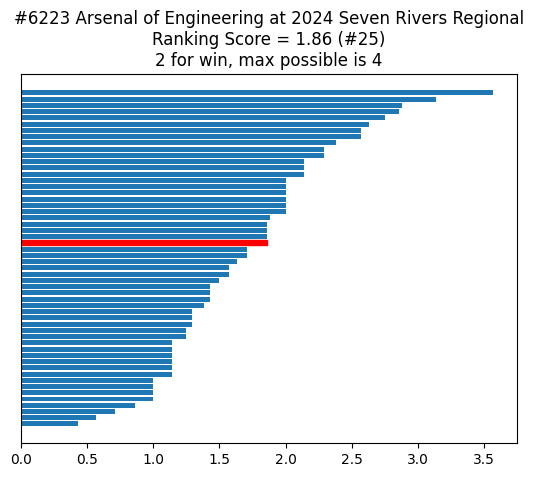

       team  Ranking Score                             Name
0   frc7021           3.57                      TC Robotics
1   frc1710           3.14          The Ravonics Revolution
2   frc8802           2.88                 Milwaukee United
3   frc2704           2.86                 Roaring Robotics
4   frc2129           2.75                      Ultraviolet
5   frc2826           2.63                    Wave Robotics
6   frc2830           2.57             Riverside RoboTigers
7   frc2194           2.57                       Fondy Fire
8   frc3082           2.38                  Chicken Bot Pie
9   frc4230           2.29                       TopperBots
10  frc5914           2.29                 Robotic Warriors
11  frc1675           2.14  UPS (Ultimate Protection Squad)
12  frc6166           2.14                      Thorobotics
13  frc2202           2.14                   BEAST Robotics
14  frc5826           2.00                    Avis Automata


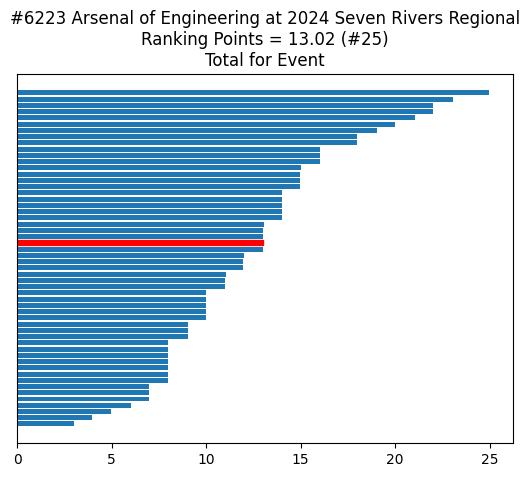

       team  Ranking Points                             Name
0   frc7021           24.99                      TC Robotics
1   frc8802           23.04                 Milwaukee United
2   frc2129           22.00                      Ultraviolet
3   frc1710           21.98          The Ravonics Revolution
4   frc2826           21.04                    Wave Robotics
5   frc2704           20.02                 Roaring Robotics
6   frc3082           19.04                  Chicken Bot Pie
7   frc2830           17.99             Riverside RoboTigers
8   frc2194           17.99                       Fondy Fire
9   frc5914           16.03                 Robotic Warriors
10  frc4230           16.03                       TopperBots
11   frc525           16.00                        Swartdogs
12  frc1716           15.04                 Redbird Robotics
13  frc2202           14.98                   BEAST Robotics
14  frc1675           14.98  UPS (Ultimate Protection Squad)


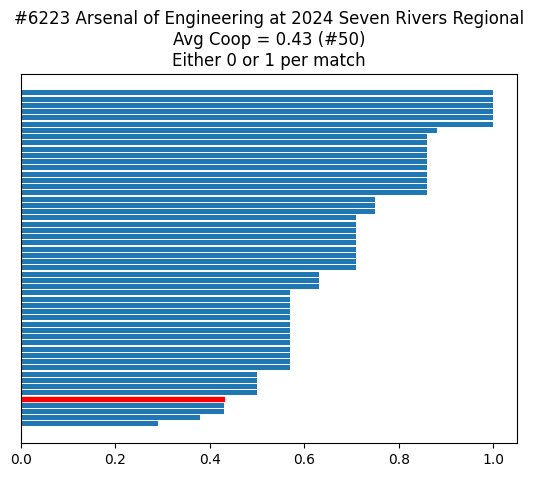

       team  Avg Coop                             Name
0   frc2202      1.00                   BEAST Robotics
1   frc8024      1.00                         Robotans
2   frc1710      1.00          The Ravonics Revolution
3   frc1306      1.00                       BadgerBOTS
4   frc5826      1.00                    Avis Automata
5   frc1675      1.00  UPS (Ultimate Protection Squad)
6   frc7619      0.88                       illumiBOTi
7   frc4054      0.86                 Phoenix Robotics
8   frc3090      0.86                 Chaotic Robotics
9   frc8531      0.86                   TermiKnightors
10  frc9676      0.86                   Hub City STEAM
11  frc5586      0.86                     Bond Brigade
12  frc5903      0.86                         ThorBots
13  frc2704      0.86                 Roaring Robotics
14   frc537      0.86                 Charger Robotics


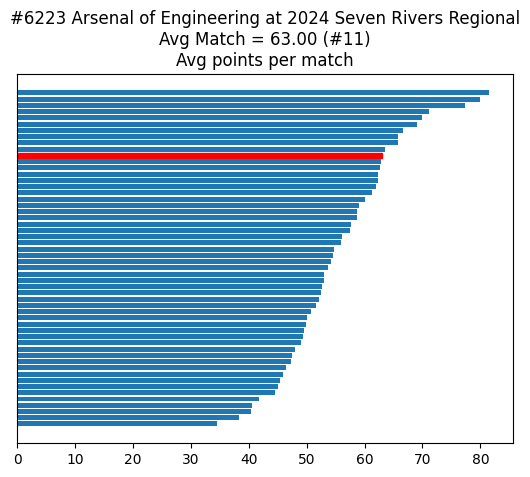

       team  Avg Match                     Name
0   frc7021      81.57              TC Robotics
1   frc2129      80.00              Ultraviolet
2   frc8802      77.38         Milwaukee United
3   frc1710      71.14  The Ravonics Revolution
4   frc2830      70.00     Riverside RoboTigers
5   frc4230      69.14               TopperBots
6   frc2704      66.71         Roaring Robotics
7   frc2194      65.86               Fondy Fire
8   frc2202      65.86           BEAST Robotics
9   frc1625      63.57              Winnovation
10  frc6223      63.00   Arsenal of Engineering
11  frc9576      62.86        Loretto Lightning
12   frc525      62.75                Swartdogs
13  frc3082      62.38          Chicken Bot Pie
14   frc171      62.29         Cheese Curd Herd


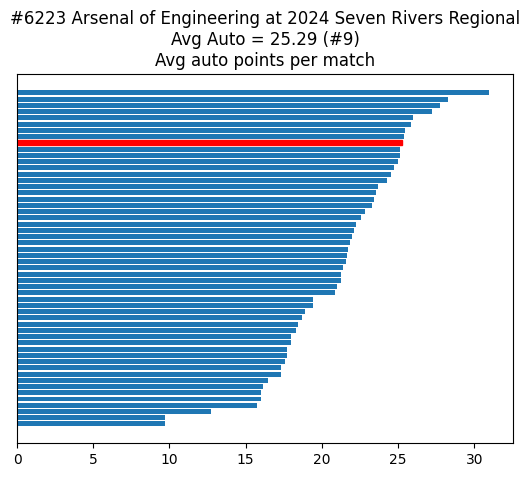

       team  Avg Auto                                          Name
0   frc7021     31.00                                   TC Robotics
1   frc2830     28.29                          Riverside RoboTigers
2   frc8802     27.75                              Milwaukee United
3   frc2129     27.25                                   Ultraviolet
4   frc4230     26.00                                    TopperBots
5   frc1675     25.86               UPS (Ultimate Protection Squad)
6   frc1710     25.43                       The Ravonics Revolution
7    frc525     25.38                                     Swartdogs
8   frc6223     25.29                        Arsenal of Engineering
9   frc2506     25.14                                Saber Robotics
10  frc6166     25.14                                   Thorobotics
11  frc2194     25.00                                    Fondy Fire
12  frc7103     24.71  Robo Remedy @ Mantiowoc Lutheran High School
13   frc171     24.57                           

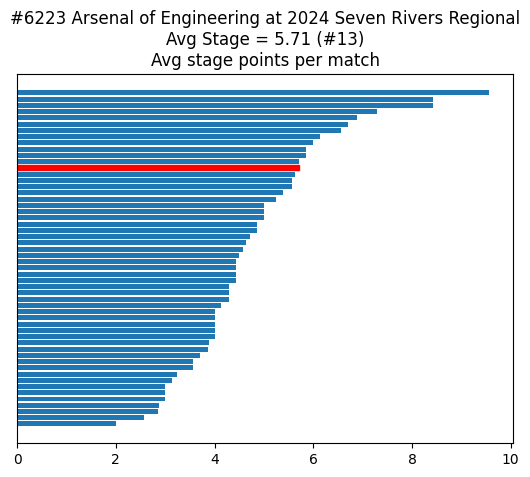

       team  Avg Stage                     Name
0   frc7021       9.57              TC Robotics
1   frc1710       8.43  The Ravonics Revolution
2   frc8024       8.43                 Robotans
3   frc2704       7.29         Roaring Robotics
4   frc3082       6.88          Chicken Bot Pie
5   frc4230       6.71               TopperBots
6   frc9578       6.57               Player One
7   frc1091       6.14           Oriole Assault
8   frc5148       6.00         New Berlin Blitz
9   frc5903       5.86                 ThorBots
10  frc6166       5.86              Thorobotics
11  frc2506       5.71           Saber Robotics
12  frc6223       5.71   Arsenal of Engineering
13  frc2129       5.63              Ultraviolet
14  frc3692       5.57         Rock N' Robotics


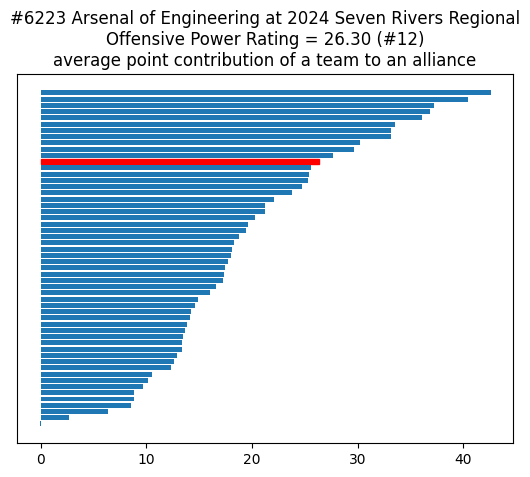

       team        opr                             Name
0   frc2129  42.560131                      Ultraviolet
1   frc7021  40.387349                      TC Robotics
2   frc2194  37.235710                       Fondy Fire
3   frc8802  36.842041                 Milwaukee United
4   frc1710  36.056455          The Ravonics Revolution
5   frc1675  33.549034  UPS (Ultimate Protection Squad)
6   frc2830  33.152110             Riverside RoboTigers
7   frc1625  33.102417                      Winnovation
8    frc525  30.214036                        Swartdogs
9   frc4230  29.647044                       TopperBots
10  frc2202  27.627489                   BEAST Robotics
11  frc6223  26.298793           Arsenal of Engineering
12  frc2826  25.556615                    Wave Robotics
13  frc3082  25.356841                  Chicken Bot Pie
14  frc9576  25.272768                Loretto Lightning


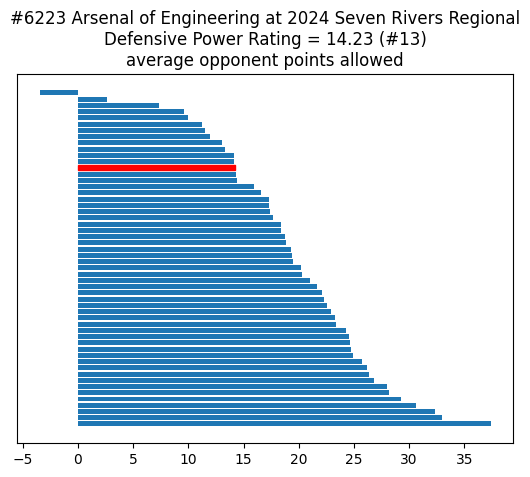

       team        dpr                             Name
0   frc5914  -3.473280                 Robotic Warriors
1   frc2826   2.636746                    Wave Robotics
2   frc5826   7.353838                    Avis Automata
3   frc3082   9.606631                  Chicken Bot Pie
4   frc2506   9.943654                   Saber Robotics
5   frc3381  11.229252                       Droid Rage
6   frc1710  11.554366          The Ravonics Revolution
7   frc6166  11.955039                      Thorobotics
8   frc1625  13.064833                      Winnovation
9   frc1716  13.302798                 Redbird Robotics
10  frc1675  14.135795  UPS (Ultimate Protection Squad)
11  frc6651  14.135977                      Golden Bots
12  frc6223  14.230506           Arsenal of Engineering
13  frc1259  14.304444                   Paradigm Shift
14  frc3692  14.399287                 Rock N' Robotics


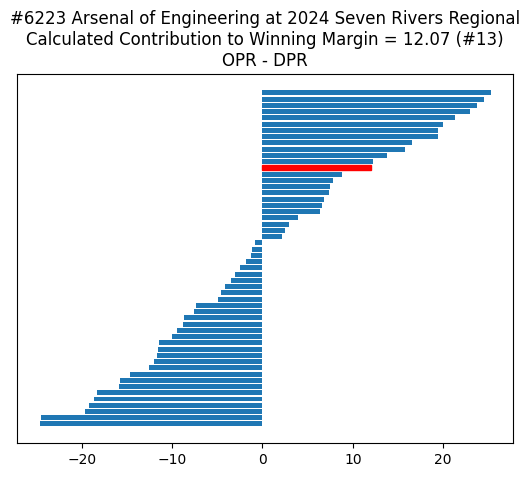

       team       ccwm                             Name
0   frc2129  25.243780                      Ultraviolet
1   frc1710  24.502089          The Ravonics Revolution
2   frc7021  23.771740                      TC Robotics
3   frc2826  22.919869                    Wave Robotics
4   frc2194  21.310300                       Fondy Fire
5   frc1625  20.037584                      Winnovation
6   frc5914  19.472523                 Robotic Warriors
7   frc1675  19.413239  UPS (Ultimate Protection Squad)
8   frc8802  16.576406                 Milwaukee United
9   frc3082  15.750210                  Chicken Bot Pie
10  frc2830  13.775962             Riverside RoboTigers
11  frc5826  12.286176                    Avis Automata
12  frc6223  12.068287           Arsenal of Engineering
13  frc1716   8.777591                 Redbird Robotics
14  frc2506   7.823989                   Saber Robotics


In [34]:
print_chart(df, 'Ranking Score', 'Ranking Score\n2 for win, max possible is 4')
print_chart(df, 'Ranking Points', 'Ranking Points\nTotal for Event')
print_chart(df, 'Avg Coop', 'Avg Coop\nEither 0 or 1 per match')
print_chart(df, 'Avg Match', 'Avg Match\nAvg points per match')
print_chart(df, 'Avg Auto', 'Avg Auto\nAvg auto points per match')
print_chart(df, 'Avg Stage', 'Avg Stage\nAvg stage points per match')

print_chart(df, 'opr', 'Offensive Power Rating\naverage point contribution of a team to an alliance')
print_chart(df, 'dpr', 'Defensive Power Rating\naverage opponent points allowed', True)
print_chart(df, 'ccwm', 'Calculated Contribution to Winning Margin\nOPR - DPR')

## Count Undefeated Teams

In [35]:
year = '2024'
url = f'https://www.thebluealliance.com/api/v3/events/{year}/simple'
events = util.call_tba_api(url).json()
event_count = 0
team_appearances = 0
undefeated = 0
for e in events:
    # Event type: 0 - regional, 1 - district...
    if datetime.strptime(e['end_date'], "%Y-%m-%d") < datetime.now() and e['event_type'] == 0:
        event_count += 1
        event_code = year + e['event_code']
        print(event_code, e['end_date'], e['name'])

        url = f'https://www.thebluealliance.com/api/v3/event/{event_code}/rankings'
        rankings = util.call_tba_api(url).json()
        teams = 0
        for r in rankings['rankings']:
            teams += 1
            if r['record']['wins'] > 0 and r['record']['losses'] == 0 and r['record']['ties'] == 0:
                team_key = r['team_key']
                url = f'https://www.thebluealliance.com/api/v3/team/{team_key}'
                t = util.call_tba_api(url).json()
                print('  ', team_key, r['rank'], t['nickname'], t['city'], t['state_prov'] )
                undefeated += 1
        team_appearances += teams
        print('  ', teams, 'teams')

# Clean up variables
del e, events, r, rankings, t, team_key, teams, url, year, event_code

print('Events:', event_count)
print('Team appearances:', team_appearances)
print('Undefeated:', undefeated, f'{undefeated/team_appearances:.1%}')


 

2024arli 2024-03-09 Arkansas Regional
   28 teams
2024ausc 2024-03-17 Southern Cross Regional
   frc8814 2 Blackhole Shanghai Shanghai
   47 teams
2024azgl 2024-03-23 Arizona East Regional
   41 teams
2024azva 2024-03-16 Arizona Valley Regional
   41 teams
2024bcvi 2024-03-02 Canadian Pacific Regional
   36 teams
2024brbr 2024-03-02 Brazil Regional
   frc1156 1 Under Control Novo Hamburgo Rio Grande do Sul
   frc9602 2 CANINTECH SINOP Mato Grosso
   frc9175 3 BrainMachine-FRC catalão Goiás
   55 teams
2024cada 2024-03-16 Sacramento Regional
   38 teams
2024cafr 2024-03-24 Central Valley Regional
   39 teams
2024cala 2024-03-17 Los Angeles Regional
   frc368 1 Team Kika Mana Honolulu Hawaii
   44 teams
2024camb 2024-03-30 Monterey Bay Regional
   frc1323 1 MadTown Robotics Madera California
   frc604 2 Quixilver San Jose California
   36 teams
2024caoc 2024-03-30 Orange County Regional
   frc5199 1 Robot Dolphins From Outer Space Dana Point California
   48 teams
2024caph 2024-03-03 Hue